# Multiclass classification using Softmax

We now extend logistic regression to multiclas classification using [softmax](https://en.wikipedia.org/wiki/Softmax_function).

The problem requires us to do three-classes classification using a Softmax function, which can be easily considered as an extension of logistic regression over three (or more) classes. We use the neural network-like implementation as with binary classification.

Luckily, Keras provides a [softmax activation function](https://keras.io/api/layers/activations/#softmax-function), which we will use instead of the logistic we previously used.

The structure of our network will be similar, but the output goes from a single number to **three** numbers, one per class, and we thus need three nodes:

<img src="https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/softmax_neuron.png">

As a result, the loss function will need to change. Remember, loss represents a measure of how good the predictions are. Previously we used binary_crossentropy, but since now predictions are multiclass we need to change function. Luckily Keras provides a natural extension for the multiclass case with [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)


## Categorical data

As usual, we first import some necessary libraries and load the data: as we did with binary classification, we first take only two features from the dataset.

In [1]:
## import libraries
import numpy as np
import tensorflow
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

In [2]:
iris = sklearn.datasets.load_iris()
iris.data = pd.DataFrame(iris.data, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(iris.target) #converting numpy array -> pandas Series
iris.target = iris.target.to_frame() #converting Pandas series to dataframe

features = iris.data.iloc[:,0:2]
target = iris.target

feature_x = 0
feature_y = 1

We can re-plot the data to check their distribution in the two-feature space:

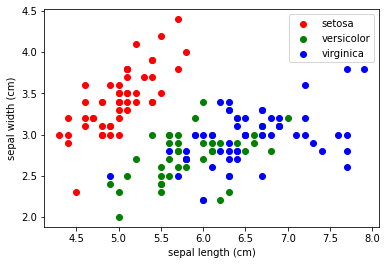

In [3]:
#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

We now check the dimensions of our input arrays (a sanity check which is important with neural networks and deep learning):

In [4]:
print('Shape of the feature table: ' + str(features.shape))
print('Shape of the target array: ' + str(target.shape))

Shape of the feature table: (150, 2)
Shape of the target array: (150, 1)


The problem is that our target array `iris.target` is a numeric array. But those numbers we used (0, 1, and 2) do not represent real values. In other words, "virginica" is not twice "versicolor". Numbers here are used as labels, not as quantities.

In fact, to properly train a model the structure of the target array must change to [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). In simple terms, it needs to become a table with one row per sample (150 in total) and one column per class (three in total). Something like:

| Setosa | Versicolor | Virginica |
|------|------|------|
|   0  |   1  |   0  |
|   1  |   0  |   0  |
|   1  |   0  |   0  |
|   0  |   0  |   1  |

As you can see the first sample is Versicolor, the second and third are Setosa, the last one is Virginica. Note that there is only a single "one" per row.

Luckily, it's easy to pass to one-hot encoding using keras function [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function):


In [5]:
#the "utils" subpackage is very useful, take a look to it when you have time
from keras.utils import to_categorical

#converting to categorical
target_multi_cat = to_categorical(target)

#since everything else is a Pandas dataframe, let's stick to the format
#for consistency
target_multi_cat = pd.DataFrame(target_multi_cat)

#let's take a look
print(target_multi_cat)

       0    1    2
0    1.0  0.0  0.0
1    1.0  0.0  0.0
2    1.0  0.0  0.0
3    1.0  0.0  0.0
4    1.0  0.0  0.0
..   ...  ...  ...
145  0.0  0.0  1.0
146  0.0  0.0  1.0
147  0.0  0.0  1.0
148  0.0  0.0  1.0
149  0.0  0.0  1.0

[150 rows x 3 columns]


## Training and validation sets

We are now ready to create our training and validation sets, as done above:

In [6]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

test_pct = 0.2

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
#random_state is used to control class balance between training and test sets (None to switch to random behavior)
sss = StratifiedShuffleSplit(n_splits=1, test_size= test_pct, random_state=0)

for train_index, val_index in sss.split(features, target_multi_cat):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target_multi_cat.iloc[train_index, :]
    target_val     = target_multi_cat.iloc[val_index, :]

Just a little check:

In [7]:
#shapes
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

#number of classes per split
print('\nClasses in train set:')
print(target_train.sum())
print('\nClasses in validation set:')
print(target_val.sum())

(120, 2)
(30, 2)
(120, 3)
(30, 3)

Classes in train set:
0    40.0
1    40.0
2    40.0
dtype: float32

Classes in validation set:
0    10.0
1    10.0
2    10.0
dtype: float32


We have now a balanced dataset, with 40 instances for each class in the training set and 10 in the validation set.

## Set up

We define here the hyperparameters of the model

In [22]:
num_classes = 3
input_shape = features_train.shape[1]
activation_function = 'softmax'
optimising_method = 'rmsprop'
loss_function = 'categorical_crossentropy'
num_epochs = 500

## A multiclass model

We are now ready to declare our multiclass classification model: we use `Keras`, but this is equivalent to multiclass logistic regression (only with neural networks-like representation). The output layer has three units, corresponding to the three classes:

In [23]:
from keras.models import Sequential
from keras.layers import Dense

# 3-class softmax regression in Keras
model_multi = Sequential()
model_multi.add(Dense(units = num_classes, activation=activation_function, input_dim=input_shape))

#compile the model specifying the new multiclass loss
model_multi.compile(optimizer=optimising_method, loss=loss_function)

Let's take a look under the hood:

In [14]:
print(model_multi.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


We now have to train 9 parameters: 3 coefficients (W1, W2 B) times tree nodes.

## Fitting the model 

We are ready to fit the model. This time we go directly to 500 epochs, trained in silent mode. We then plot the loss function evolution.

In [24]:
history_multi = model_multi.fit(features_train, target_train, epochs=num_epochs, validation_data=(features_val, target_val), verbose=0)

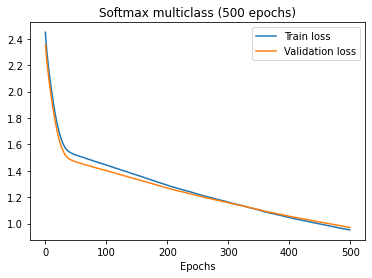

In [25]:
#function to take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history(history_multi, 'Softmax multiclass ({} epochs)'.format(num_epochs))

This looks promising. There's the clear same pattern we saw with logistic regression, with a strong improvement in the first hundred epochs (and then things become slow...)

## Decision boundary

We want now to plot again the decision boundary. Unfortunately `plot_decision_regions` function from [mlxtend](http://rasbt.github.io/mlxtend/) module does not support one-hot encoded multiclasses natively. Luckily [there's a quick workaround](https://www.machinecurve.com/index.php/2019/10/17/how-to-use-categorical-multiclass-hinge-with-keras/#visualizing-the-decision-boundary), but if you get lost in the code don't worry and just look at the plot :) 

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


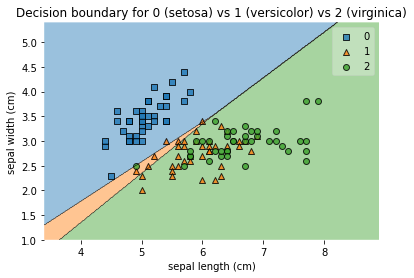

In [26]:
#we define a class to take the Keras model and convert its predictions
#from "one probability per iris type" to "just the iris type with the highest probability"
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)

#we wrap our trained model, instantiating a new object
keras_model_no_ohe = Onehot2Int(model_multi)

#and we can now plot the decision boundary safely (we still need to convert
#the target one-hot-encoded matrix to int, though)
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(features_train.to_numpy(), np.argmax(target_train.to_numpy(), axis=1), 
                      clf=keras_model_no_ohe)
plt.title('Decision boundary for 0 (setosa) vs 1 (versicolor) vs 2 (virginica)')
plt.xlabel(iris.feature_names[feature_x])
plt.ylabel(iris.feature_names[feature_y])
plt.show()

### Predictions

We now look at predictions in the **test set**: each test sample is assigned to the class with the highest probability.

Predicted classes are then compared to true classes in a confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix

predictions = model_multi.predict(features_val)
print(predictions)

predicted_classes = model_multi.predict_classes(features_val)
predicted_classes = predicted_classes.reshape(len(predicted_classes),1)

target_classes = target.iloc[val_index].to_numpy()

con_mat_df = confusion_matrix(target_classes, predicted_classes, labels = [0,1,2])
print("\nConfusion matrix:")
print(con_mat_df)

[[0.31410113 0.3288501  0.35704878]
 [0.30870637 0.33135006 0.35994354]
 [0.2767595  0.31631058 0.4069299 ]
 [0.39342147 0.347037   0.2595415 ]
 [0.24705233 0.30438897 0.44855872]
 [0.30691954 0.33217755 0.3609029 ]
 [0.42405888 0.3484314  0.2275097 ]
 [0.26715314 0.3143649  0.41848192]
 [0.27341208 0.31771487 0.40887305]
 [0.29064444 0.32796255 0.38139307]
 [0.38243946 0.34307104 0.2744895 ]
 [0.3327022  0.33684057 0.33045727]
 [0.25157684 0.30864626 0.43977684]
 [0.40388083 0.3460257  0.25009355]
 [0.29324558 0.32680395 0.3799505 ]
 [0.43869197 0.34860903 0.21269903]
 [0.42934352 0.3498197  0.22083686]
 [0.26093194 0.31092453 0.42814356]
 [0.2478344  0.30408803 0.44807753]
 [0.24239531 0.3061802  0.45142454]
 [0.24008924 0.30706623 0.45284453]
 [0.4291745  0.3453935  0.22543195]
 [0.41567388 0.34874028 0.23558582]
 [0.4166903  0.3481454  0.23516428]
 [0.31605694 0.3336189  0.35032415]
 [0.26093194 0.31092453 0.42814356]
 [0.30870637 0.33135006 0.35994354]
 [0.41233006 0.34597275 0.24

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


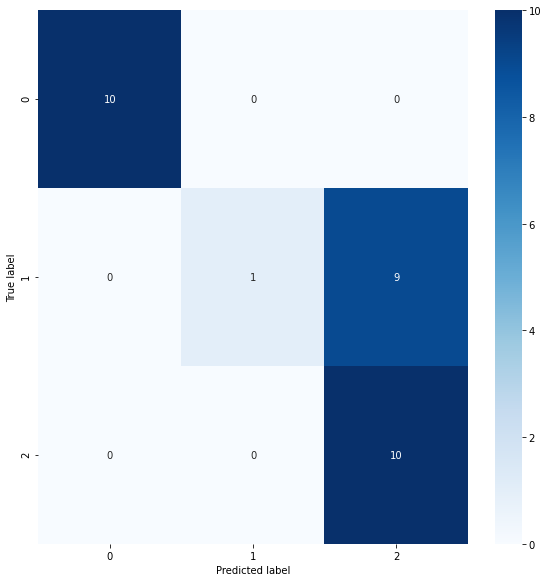

In [28]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(target_classes, predicted_classes)
print("Overall accuracy is: ", accuracy)

confusion_matrix(target_classes, predicted_classes, normalize='true')

Overall accuracy is:  0.7


array([[1. , 0. , 0. ],
       [0. , 0.1, 0.9],
       [0. , 0. , 1. ]])

## Exercise: do it yourself!

In the above illustration we three keras units with softmax activation function to perform logistic regression the `Iris` dataset. Only two features were used.

It is again time for you to try write your own code!

You can:

* try out the effect of including the other two features, which we excluded above. Does performance improve? 
* what happens if you increase the n. of epochs?
* what happens if you change the training/test data split?
* what is the error rate in the training set?

# Shallow neural networks for softmax regression

We now move on from multinomial logistic regression to softmax regression with neural networks: again, we start by implementing a shallow neural netowrk model.

First, we select all four features from the dataset and configure some basic parameters:

In [30]:
## select all 4 features
features = iris.data.iloc[:,:]

In [33]:
## # Configuration options
num_classes = 3
input_shape = (features.shape[1],)
hidden_nodes = 8
hidden_activation = 'relu'
output_activation = 'softmax'
loss_function = 'categorical_crossentropy'
optimizer_used = 'rmsprop' ## or keras.optimizers.adam(lr=0.001)? maybe for softmax regression?

In [34]:
# 3-class softmax regression in Keras
model_multi = Sequential()
model_multi.add(Dense(units=hidden_nodes, input_shape=input_shape, activation=hidden_activation))
model_multi.add(Dense(num_classes, activation='softmax'))

#compile the model specifying the new multiclass loss
model_multi.compile(optimizer='rmsprop', loss=loss_function)

In [35]:
print(model_multi.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
None


We see that we have 67 parameters to train: 5 parameters (w1 ... w4, b) times 8 nodes in the hidden layer; 9 parameters (8 units + b) times three nodes in the output layer.

## Training and test sets

We split the data in the training and test sets:

In [36]:
#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

#the .split() method returns (an iterable over) two lists which can be
#used to index the samples that go into train and validation sets
for train_index, val_index in sss.split(features, target_multi_cat):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target_multi_cat.iloc[train_index,:]
    target_val     = target_multi_cat.iloc[val_index,:]
    
#let's print some shapes to get an idea of the resulting data structure
print("Training features size: ", features_train.shape)
print("Test features size: ", features_val.shape)
print("Training targets size: ", target_train.shape)
print("Test targets size: ", target_val.shape)

print("Type of the training features object: ", type(features_train))
print("Type of the training targets object: ", type(target_train))

Training features size:  (120, 4)
Test features size:  (30, 4)
Training targets size:  (120, 3)
Test targets size:  (30, 3)
Type of the training features object:  <class 'pandas.core.frame.DataFrame'>
Type of the training targets object:  <class 'pandas.core.frame.DataFrame'>


In [37]:
#number of classes per split
print('\nClasses in train set:')
print(target_train.sum())
print('\nClasses in validation set:')
print(target_val.sum())


Classes in train set:
0    40.0
1    40.0
2    40.0
dtype: float32

Classes in validation set:
0    10.0
1    10.0
2    10.0
dtype: float32


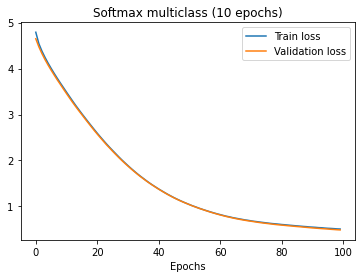

In [38]:
history_multi = model_multi.fit(features_train, target_train, epochs=100, 
                     validation_data=(features_val, target_val), verbose=0)

plot_loss_history(history_multi, 'Softmax multiclass (10 epochs)')

In [39]:
from sklearn.metrics import confusion_matrix

predictions = model_multi.predict(features_val)
print(predictions)

predicted_classes = model_multi.predict_classes(features_val)
target_classes = target.iloc[val_index,:].to_numpy()
con_mat_df = confusion_matrix(target_classes, predicted_classes)
print(con_mat_df)

[[0.09798066 0.19749956 0.70451975]
 [0.12986708 0.39093408 0.47919887]
 [0.10094113 0.21612138 0.68293756]
 [0.7733041  0.17651041 0.05018554]
 [0.12051649 0.34655407 0.5329295 ]
 [0.13026792 0.39836758 0.4713645 ]
 [0.783623   0.1597431  0.05663399]
 [0.12039737 0.327155   0.5524476 ]
 [0.09987248 0.25324827 0.6468792 ]
 [0.16831237 0.5336295  0.29805818]
 [0.8788872  0.1001339  0.02097888]
 [0.15130515 0.41697314 0.4317217 ]
 [0.13578601 0.5040137  0.36020023]
 [0.81942785 0.13968225 0.04088996]
 [0.14393756 0.51569235 0.34037   ]
 [0.7893121  0.15174778 0.05894003]
 [0.799078   0.15217811 0.04874391]
 [0.19278918 0.50169015 0.30552074]
 [0.167371   0.5176209  0.31500816]
 [0.12627071 0.3761552  0.49757412]
 [0.12038147 0.3857593  0.49385923]
 [0.85020816 0.10851213 0.04127968]
 [0.7499058  0.18488659 0.06520762]
 [0.7472353  0.18498375 0.06778093]
 [0.11196113 0.24122366 0.64681524]
 [0.13958736 0.49303332 0.3673793 ]
 [0.14575449 0.45958233 0.39466316]
 [0.8457239  0.11919979 0.03

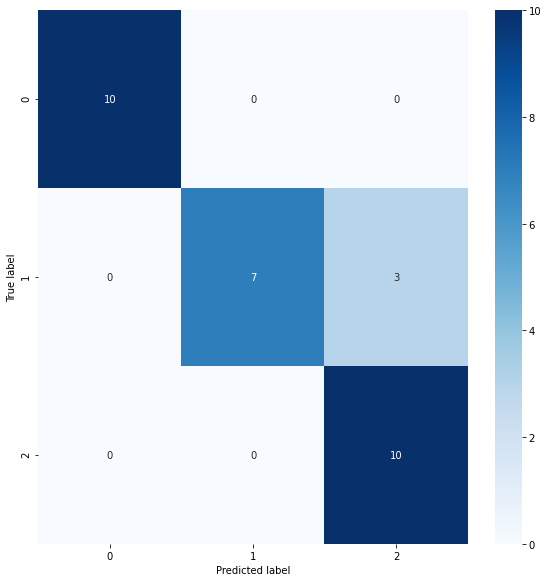

In [40]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
accuracy = accuracy_score(target_classes, predicted_classes)
print("Overall accuracy is: ", accuracy)

confusion_matrix(target_classes, predicted_classes, normalize='true')

Overall accuracy is:  0.9


array([[1. , 0. , 0. ],
       [0. , 0.7, 0.3],
       [0. , 0. , 1. ]])